In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing as pc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve, auc
from sklearn import metrics, tree
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from minepy import MINE
from tqdm import *

In [2]:
def plot_roc(y_true, y_score):
    plt.figure(figsize=(5, 5))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.4f' % roc_auc)
    plt.legend(loc=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig('可视化/决策树分类roc.png')
    plt.show()

def draw_heatmap(mics:pd.DataFrame, title="MIC热力图"):
      rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
      sns.set_theme(font_scale=0.9,rc=rc)
      plt.title(title)
      sns.heatmap(mics,
                  annot=True,  # 显示相关系数的数据
                  center=0.5,  # 居中
                  fmt='.2f',  # 只显示两位小数
                  vmin=0, vmax=1,  # 设置数值最小值和最大值
                  xticklabels=True, yticklabels=True,  # 显示x轴和y轴
                  square=True,  # 每个方格都是正方形
                  cbar=True,  # 绘制颜色条
                  linewidths=.5,
                  cmap="OrRd",        #刻度颜色
                  annot_kws={"size": 10}
                  )
      plt.show()

# 数据处理

In [3]:
df1 = pd.read_csv('东方财富个股资金流.csv')

In [4]:
df1

,股票代码,股票名称,最新价,今日涨跌额,今日主力净流入净额,今日主力净流入净占比,今日超大单净流入净额,今日超大单净流入净占比,今日大单净流入净额,今日大单净流入净占比,今日中单净流入净额,今日中单净流入净占比,今日小单净流入净额,今日小单净流入净占比
0,2156,通富微电,24.20,9.95,927771264.0,23.87,1.061478e+09,27.31,-133707104.0,-3.44,-507233920.0,-13.05,-420537344.0,-10.82
1,300496,中科创达,93.40,11.92,342651329.0,19.37,1.327192e+08,7.50,209932080.0,11.87,-187569920.0,-10.60,-155081392.0,-8.77
2,601138,工业富联,17.44,3.87,276073648.0,8.30,4.402536e+08,13.24,-164179920.0,-4.94,-276323184.0,-8.31,249520.0,0.01
3,2558,巨人网络,18.63,9.98,255118880.0,15.70,2.674040e+08,16.45,-12285104.0,-0.76,-129386288.0,-7.96,-125732612.0,-7.74
4,688012,中微公司,170.62,3.70,198571491.0,12.84,8.808306e+07,5.69,110488432.0,7.14,-83951392.0,-5.43,-114620112.0,-7.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5041,300750,宁德时代,216.56,-1.56,-405879120.0,-17.32,-3.737073e+08,-15.94,-32171824.0,-1.37,153702320.0,6.56,252176831.0,10.76
5042,300418,昆仑万维,52.13,0.06,-484971296.0,-12.48,-3.418707e+08,-8.79,-143100640.0,-3.68,222203808.0,5.72,262767488.0,6.76
5043,2236,大华股份,19.18,-9.91,-487212384.0,-19.99,-4.100998e+08,-16.83,-77112608.0,-3.16,166297184.0,6.82,320915200.0,13.17
5044,300059,东方财富,14.66,-3.17,-834101808.0,-28.89,-4.080299e+08,-14.13,-426071904.0,-14.76,268769872.0,9.31,565331936.0,19.58


In [5]:
# 删除无数值意义的数据
df1.drop(columns=['股票代码', '股票名称'], inplace=True)

In [6]:
k1 = df1.isnull().sum()
k1.sort_values(ascending=False, inplace=True)
k1
# 发现没有缺失值，不需要额外处理

最新价            0
今日涨跌额          0
今日主力净流入净额      0
今日主力净流入净占比     0
今日超大单净流入净额     0
今日超大单净流入净占比    0
今日大单净流入净额      0
今日大单净流入净占比     0
今日中单净流入净额      0
今日中单净流入净占比     0
今日小单净流入净额      0
今日小单净流入净占比     0
dtype: int64

In [7]:
# 对数据进行规范化，标准化化为均值为0，标准差为1的数据
nm = pc.scale(df1)
df_nm = pd.DataFrame(nm, columns=df1.columns)

In [8]:
# 划分测试集、训练集
col = ['最新价', '今日主力净流入净额', '今日主力净流入净占比', '今日超大单净流入净额', '今日超大单净流入净占比',
       '今日大单净流入净额', '今日大单净流入净占比', '今日中单净流入净额', '今日中单净流入净占比', '今日小单净流入净额',
       '今日小单净流入净占比']
x = df_nm[col]
y = df_nm['今日涨跌额']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8)

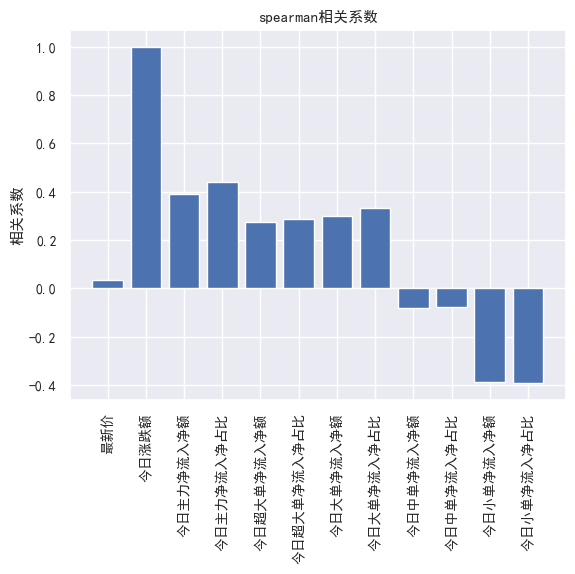

In [9]:
# 今日涨跌额与其他数据的spearman相关系数
tmk = df_nm.corr(method='spearman')
stmk = tmk['今日涨跌额']
# print(stmk.sort_values(ascending=False))


rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set_theme(font_scale=0.9,rc=rc)

plt.bar(stmk.keys(), stmk.values)
plt.xticks(rotation=90)
plt.title('spearman相关系数')
plt.ylabel('相关系数')
plt.show()

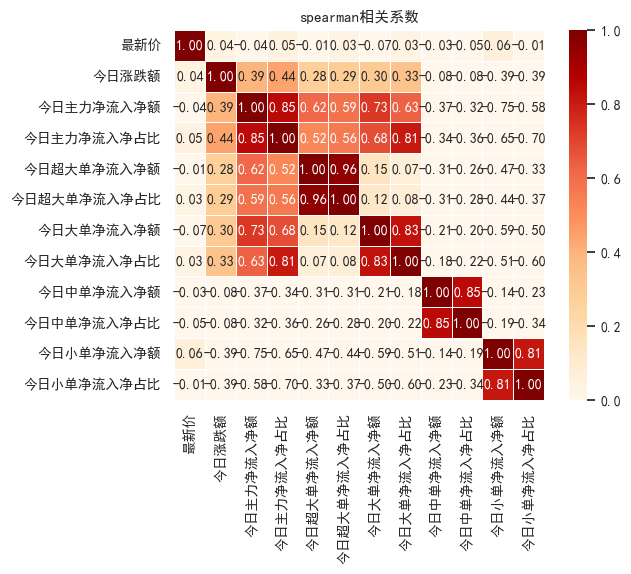

In [10]:
draw_heatmap(tmk, 'spearman相关系数')

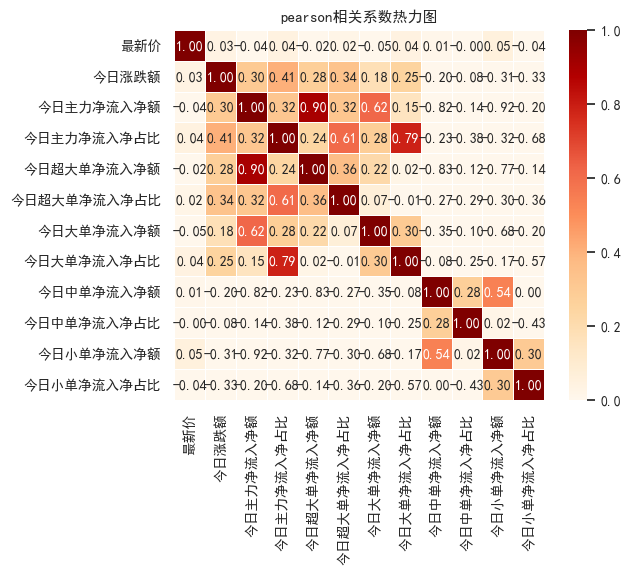

In [11]:
# 绘出pearson相关系数热力图
cor = df_nm.corr('pearson')

# plt.title('pearson相关系数热力图')
# sns.heatmap(cor,
#             annot=True,  # 显示相关系数的数据
#             center=0.5,  # 居中
#             fmt='.1f',  # 只显示两位小数
#             vmin=0, vmax=1,  # 设置数值最小值和最大值
#             xticklabels=True, yticklabels=True,  # 显示x轴和y轴
#             square=True,  # 每个方格都是正方形
#             cbar=True  # 绘制颜色条
#             )
# plt.savefig("可视化/皮尔逊相关系数热力图.png")
# plt.show()
draw_heatmap(cor, 'pearson相关系数热力图')

100%|██████████| 144/144 [02:02<00:00,  1.17it/s]


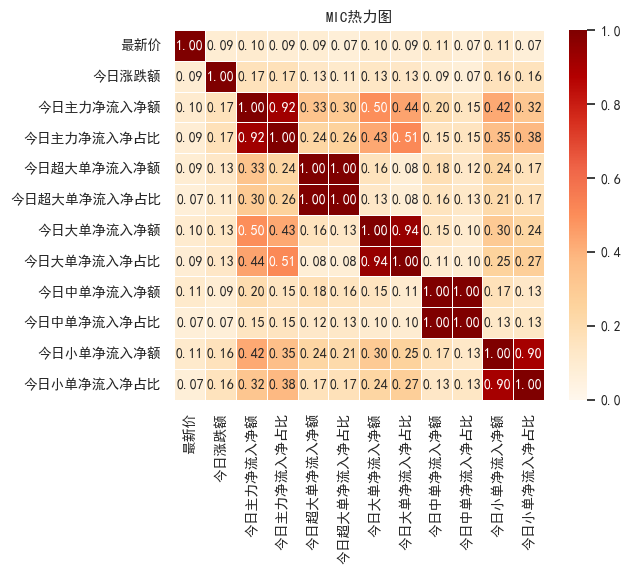

In [12]:
data = df_nm
mine = MINE(alpha=0.6, c=15)
mics = []
with tqdm(total=12**2) as pbar:
    for x in data:
        tl = []
        for y in data:
            mine.compute_score(data[x], data[y])
            tl.append(mine.mic())
            pbar.update(1)
        mics.append(tl)

draw_heatmap(pd.DataFrame(mics, index=data.columns, columns=data.columns))

# 数据分析

## PCA

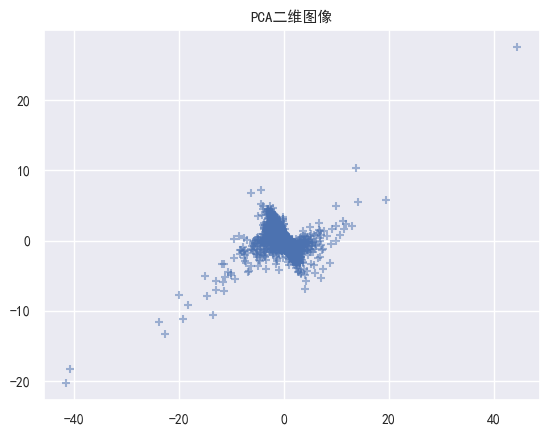

[0.3766939  0.18200853] 0.5587024312491886
[4.52122285 2.18453525]


In [17]:
# 使用PCA将12个维度的数据压缩到两个维度上，绘出散点图
pca2d = PCA(n_components=2)
pca2d.fit(df_nm)
x = pca2d.transform(df_nm)
plt.title('PCA二维图像')
plt.scatter(x[:, 0], x[:, 1], marker='+', alpha=0.5)
plt.show()

print(pca2d.explained_variance_ratio_, pca2d.explained_variance_ratio_.sum())
print(pca2d.explained_variance_)

In [18]:
# 经测试，5维条件下所含信息能够达到0.85
pca = PCA(n_components=5)
pca.fit(df_nm)
x = pca.transform(df_nm)
print(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())
print(pca.explained_variance_)

[0.3766939  0.18200853 0.12101695 0.09709883 0.08236253] 0.859180741924645
[4.52122285 2.18453525 1.45249123 1.1654169  0.98854632]


## FFN回归预测今日涨跌额

In [19]:
class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        self.ffn = nn.Sequential(
            nn.Linear(11, 128),
            nn.Sigmoid(),
            nn.Linear(128, 1)            
        )
    
    def forward(self, x):
        return self.ffn(x)

In [20]:
xt_train = torch.from_numpy(x_train.to_numpy()).to(torch.float32)
xt_test = torch.from_numpy(x_test.to_numpy()).to(torch.float32)
yt_train = torch.from_numpy(y_train.to_numpy()).to(torch.float32).reshape(-1, 1)
yt_test = torch.from_numpy(y_test.to_numpy()).to(torch.float32).reshape(-1, 1)

In [42]:
loss_train = []
loss_valid = []

In [43]:
net = FFN()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss_func = nn.MSELoss()
for t in range(400):
    pred = net(xt_train)
    loss = loss_func(pred, yt_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        loss_train.append(mean_squared_error(yt_train, pred))
        loss_valid.append(mean_squared_error(yt_test, net(xt_test)))

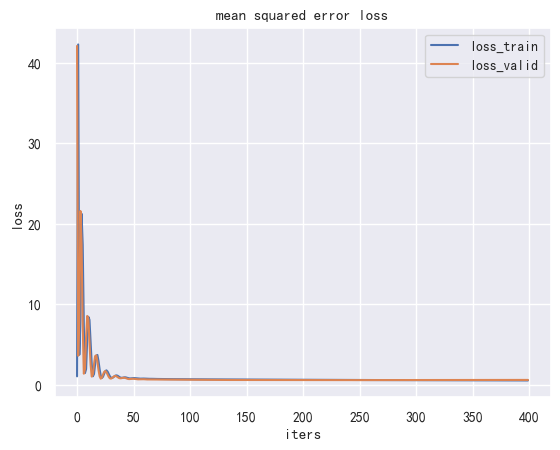

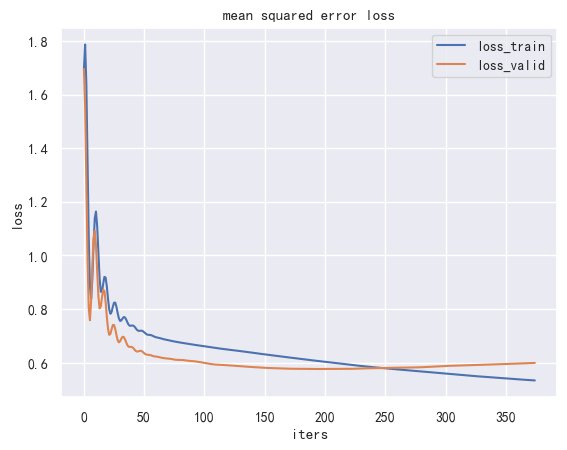

In [44]:
plt.plot(loss_train, label='loss_train')
plt.plot(loss_valid, label='loss_valid')
plt.xlabel('iters')
plt.ylabel('loss')
plt.title('mean squared error loss')
plt.legend()
plt.show()

plt.plot(loss_train[25:], label='loss_train')
plt.plot(loss_valid[25:], label='loss_valid')
plt.xlabel('iters')
plt.ylabel('loss')
plt.title('mean squared error loss')
plt.legend()
plt.show()

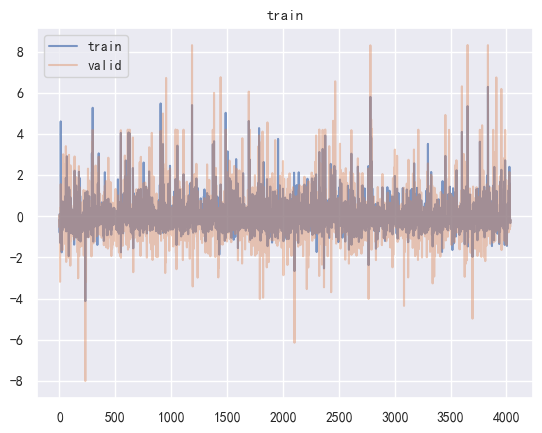

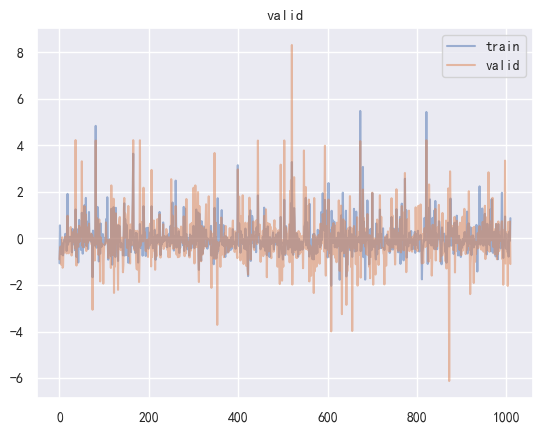

In [45]:
with torch.no_grad():
    plt.title('train')
    plt.plot(net(xt_train), alpha=0.7, label='train')
    plt.plot(yt_train, alpha=0.4, label='valid')
    plt.legend()
    plt.show()
    
    plt.title('valid')
    plt.plot(net(xt_test), alpha=0.5, label='train')
    plt.plot(yt_test, alpha=0.5, label='valid')
    plt.legend()
    plt.show()

## 决策树分类今日涨跌情况

In [25]:
y_train = y_train.map(lambda x: 0 if x < 0 else 1)
y_test = y_test.map(lambda x: 0 if x < 0 else 1)

网格搜索最佳参数设置： {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
网格搜索最佳得分： 0.6875605776191002
网格搜索决策树最佳得分 0.692079207920792
混淆矩阵：
 [[484  88]
 [223 215]]
accuracy score = 0.69
f1 score = 0.58
precision score = 0.71
recall score = 0.49
roc auc score = 0.67


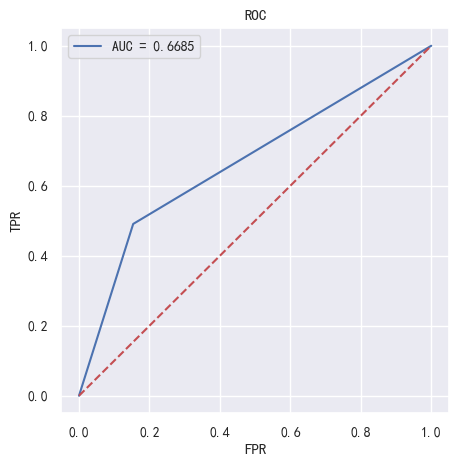

In [26]:
parameters = {
    'splitter': ('best', 'random'),
    'criterion': ('gini', 'entropy'),
    'max_depth': [*range(1, 10)]
}
dt = DT()
gs = GridSearchCV(dt, parameters, cv=5)
gs.fit(x_train, y_train)
b_param = gs.best_params_
b_score = gs.best_score_
print('网格搜索最佳参数设置：', b_param)
print('网格搜索最佳得分：', b_score)
clf = DT(
    splitter=b_param['splitter'],
    criterion=b_param['criterion'],
    max_depth=b_param['max_depth']
)
clf.fit(x_train, y_train)
pred_y = clf.predict(x_test)
print('网格搜索决策树最佳得分', clf.score(x_test, y_test))
print('混淆矩阵：\n', confusion_matrix(y_test, pred_y))
print('accuracy score = {:.2f}'.format(metrics.accuracy_score(y_test, pred_y)))
print('f1 score = {:.2f}'.format(metrics.f1_score(y_test, pred_y)))
print('precision score = {:.2f}'.format(metrics.precision_score(y_test, pred_y)))
print('recall score = {:.2f}'.format(metrics.recall_score(y_test, pred_y)))
print('roc auc score = {:.2f}'.format(metrics.roc_auc_score(y_test, pred_y)))
plot_roc(y_test, pred_y)

In [27]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=col,
    class_names=['0', '1'],
    filled=True,
    rounded=True
)
graph = graphviz.Source(dot_data, encoding='UTF-8')
graph.view('可视化/决策树可视化')

'可视化\\决策树可视化.pdf'